In [2]:
import panel as pn
import xarray as xr
import pygmt
import matplotlib.pyplot as plt

pn.extension()

In [ ]:
'''
# from previous processing - these files also contain the offset, if needed
A = xr.open_dataset('data/saojorge_A_wls_novdiff.nc')
D = xr.open_dataset('data/saojorge_D_wls_novdiff.nc')

print('preparing seasonal medians')
As= A.cum.resample(time='Q').median()
Ds= D.cum.resample(time='Q').median()
print('done')
'''

In [6]:
# let's start with pre-prepared cube (till 2022-09-30)
cube=xr.open_dataset('data/saojorge_seasons_decomposed.nc')

# number of epochs per each seasonal step
Dscount = [7, 14, 13, 11, 15, 15, 13, 15, 16, 14, 13, 8, 7, 8]
Ascount = [12, 15, 15, 16, 15, 15, 15, 14, 16, 15, 15, 7, 8, 8]
cube

<xarray.Dataset>
Dimensions:  (lat: 322, lon: 658, time: 14)
Coordinates:
  * lat      (lat) float64 38.49 38.49 38.5 38.5 ... 38.81 38.81 38.81 38.81
  * lon      (lon) float64 -28.36 -28.36 -28.36 -28.36 ... -27.71 -27.71 -27.71
  * time     (time) datetime64[ns] 2019-06-30 2019-09-30 ... 2022-09-30
Data variables:
    Us       (time, lat, lon) float32 ...
    Es       (time, lat, lon) float32 ...
    As       (time, lat, lon) float32 ...
    Ds       (time, lat, lon) float32 ...

In [7]:
# i forgot to re-reference it before. doing it now:
lon1=-27.9876
lon2=-27.9713
lat1=38.5997
lat2=38.6138
#thr=0.45
cuberef = cube.sel(lon=slice(lon1,lon2), lat=slice(lat1,lat2))
cube = cube - cuberef.median(["lat", "lon"])

In [8]:
# preparation for plot
# just fast solution, but it works
timevals = []
i=0
for a in cube.time.values:
    i=i+1
    timevals.append(i-1)

# Make a panel widget for controlling the depth plotted
depth_slider = pn.widgets.DiscreteSlider(name='LOS deformation (mm) in step', options=timevals, value=1)

# aliases
As = cube.As
Ds = cube.Ds
Es = cube.Es
Us = cube.Us

In [9]:

# Make a function for plotting with PyGMT
@pn.depends(depth=depth_slider)
def view(depth: int, save=False):
    if depth == 0:
        depth = 1
    fig = pygmt.Figure()
    pygmt.config(FONT_HEADING='22p,Helvetica-Bold,black')
    t2=str(As[depth].time.dt.quarter.values)+'.'+str(As[depth].time.dt.year.values)
    t1=str(As[depth-1].time.dt.quarter.values)+'.'+str(As[depth-1].time.dt.year.values)
    maintitle = 'deformation between Q'+t1+' and Q'+t2
    with fig.subplot(nrows=2, ncols=2, figsize=("30c", "24c"), margins=["0.75c", "0.5c"], 
                     title=maintitle, frame = 'a'): #, autolabel=True):
        with fig.set_panel(panel=0):
            pygmt.makecpt(cmap="roma", series=[-40,40])
            fig.grdimage(grid=(As[depth]-As[depth-1]), cmap=True, projection="R?") #13c") #, frame=True) #, panel=True)
            fig.colorbar(frame='a10+l"LOS deformation [mm]"')
            fig.text(position="TC", 
                     text='ascending frame',
                     #xshift = '-0.02c', yshift = '-0.01c',
                     font="22p,Helvetica-Bold,black"
                    )
            fig.text(position='MR',text='from '+str(Ascount[depth])+' epochs ', font="16p")
        with fig.set_panel(panel=1):
            pygmt.makecpt(cmap="roma", series=[-40,40])
            fig.grdimage(grid=(Ds[depth]-Ds[depth-1]), cmap=True, projection="R?")
            fig.colorbar(frame='a10+l"LOS deformation [mm]"')
            fig.text(position="TC", text='descending frame', font="22p,Helvetica-Bold,black")
            fig.text(position='MR',text='from '+str(Dscount[depth])+' epochs ', font="16p")
        with fig.set_panel(panel=2):
            pygmt.makecpt(cmap="vik", series=[-40,40])
            fig.grdimage(grid=(Us[depth]-Us[depth-1]), cmap=True, projection="R?")
            fig.colorbar(frame='a10+l"U-D/N-S deformation [mm]"')
            fig.text(position="TC", text='up-down(+N-S) component', font="22p,Helvetica-Bold,black")
        with fig.set_panel(panel=3):
            pygmt.makecpt(cmap="vik", series=[-40,40])
            fig.grdimage(grid=(Es[depth]-Es[depth-1]), cmap=True, projection="R?")
            fig.colorbar(frame='a10+l"E-W deformation [mm]"')
            fig.text(position="TC", text='east-west component', font="22p,Helvetica-Bold,black")
    if save:
        fname='step_'+str(depth)+'.png'
        fig.savefig(fname, dpi=150)
    else:
        return fig.show(dpi=100)

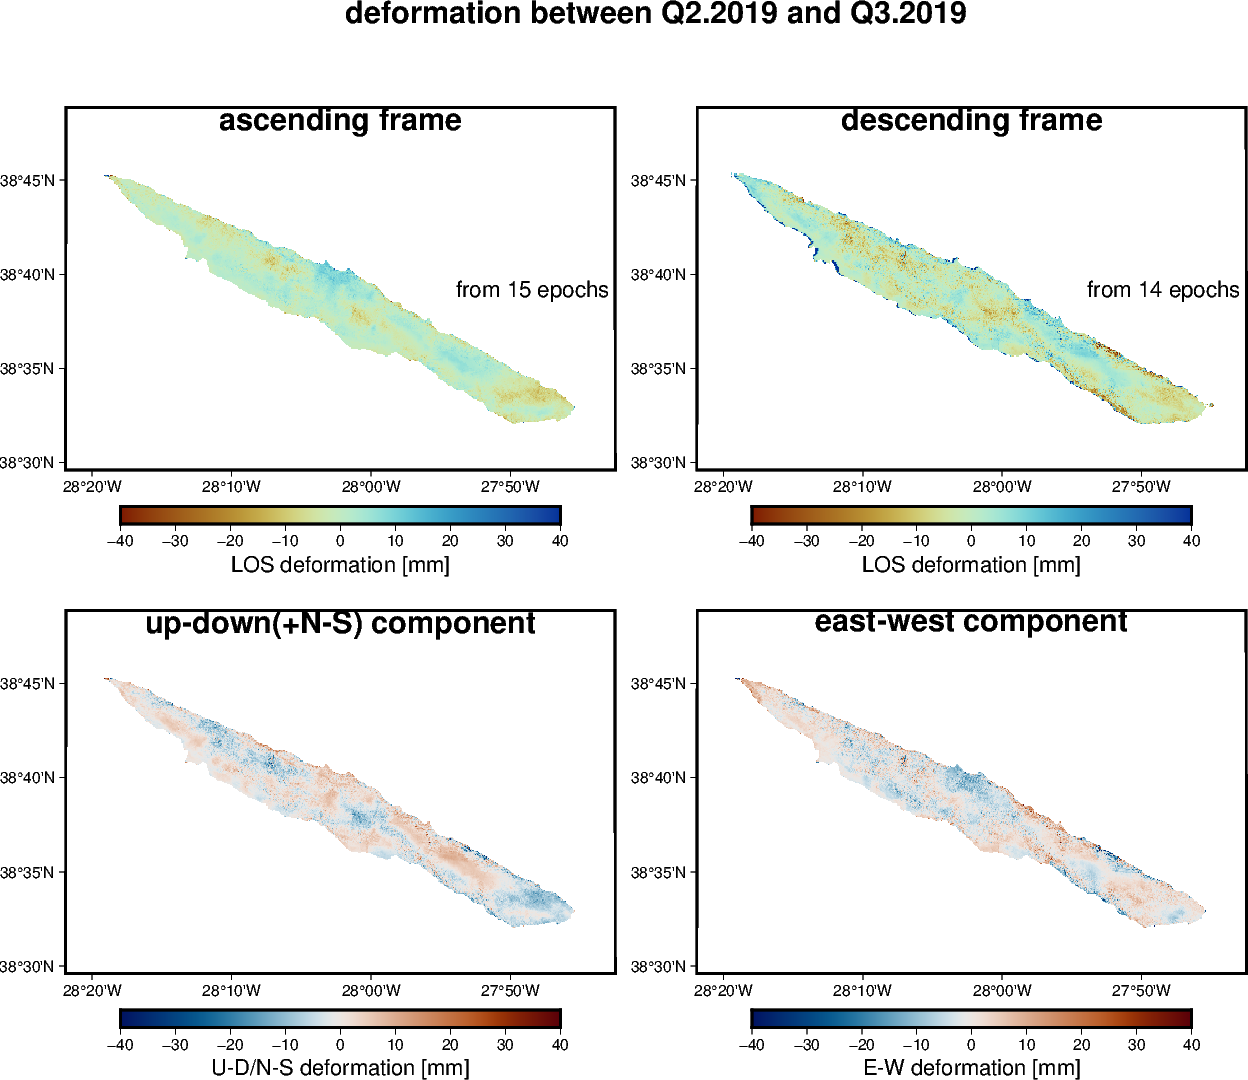

Column
    [0] DiscreteSlider(formatter='%d', name='LOS deformation (..., options=[0, 1, 2, 3, 4, ...], value=1)
    [1] ParamFunction(function)

In [25]:
pn.Column(depth_slider, view)

In [ ]:
# you can save the step to pngs:
for i in range(13):
    print('saving step '+str(i+1))
    view(i+1, save=True)

saving step 1
saving step 2


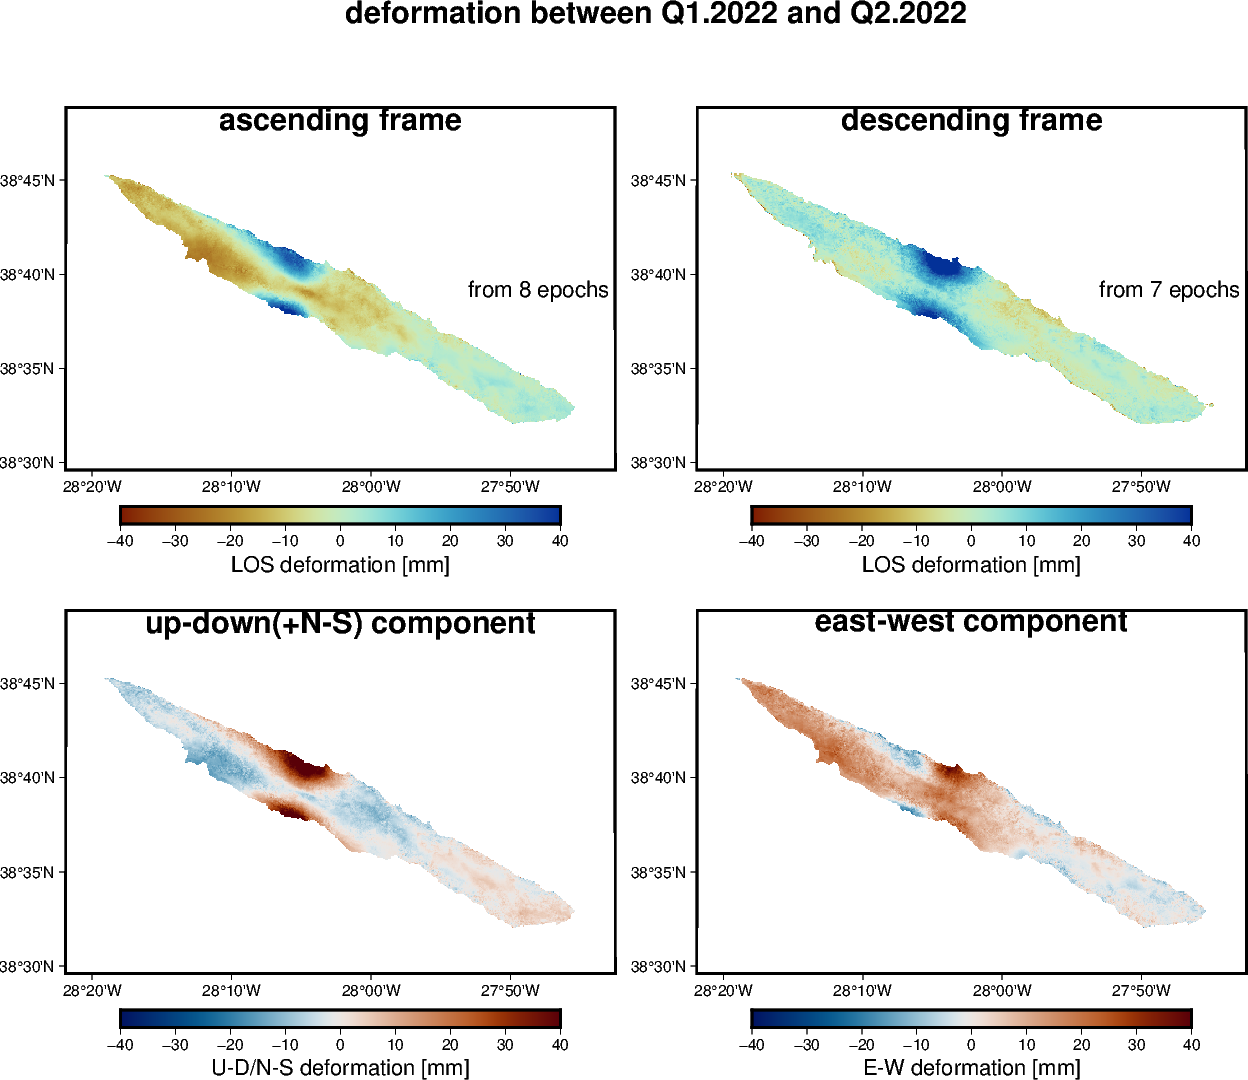

In [10]:
# or just view one of the steps directly
view(12)

In [22]:
# just to compress the stored steps
! tar -zcvf seasonal.tar.gz step*png

step_10.png
step_11.png
step_12.png
step_13.png
step_1.png
step_2.png
step_3.png
step_4.png
step_5.png
step_6.png
step_7.png
step_8.png
step_9.png
